In [152]:
import yfinance as yf
from warnings import filterwarnings
filterwarnings('ignore')
ticker = '^NSEI'
d = yf.download(ticker,period='1y',interval='1d')
d.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-08-12,16303.650391,16375.500000,16286.900391,16364.400391,16364.400391,280200
2021-08-13,16385.699219,16543.599609,16376.299805,16529.099609,16529.099609,321900
2021-08-16,16518.400391,16589.400391,16480.750000,16563.050781,16563.050781,254000
2021-08-17,16545.250000,16628.550781,16495.400391,16614.599609,16614.599609,297400
2021-08-18,16691.949219,16701.849609,16535.849609,16568.849609,16568.849609,251800


In [153]:
df = d[['Adj Close']]
ds = []
for i in range(len(df)):
    ds.append(i+1)

In [154]:
df['Day']=ds
df.head()

,Adj Close,Day
Date,,
2021-08-12,16364.400391,1
2021-08-13,16529.099609,2
2021-08-16,16563.050781,3
2021-08-17,16614.599609,4
2021-08-18,16568.849609,5


In [155]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, LeaveOneOut
pows = range(1,31)

pipe = Pipeline(steps=[
    ('poly', PolynomialFeatures(include_bias=False)),
    ('model', LinearRegression()),
])

search = GridSearchCV(
    estimator=pipe,
    param_grid={'poly__degree': pows},
    scoring='neg_mean_squared_error',
    cv=LeaveOneOut(),
)

X = df[['Day']]
Y = df[['Adj Close']]
search.fit(X,Y)

first = -search.cv_results_['mean_test_score']

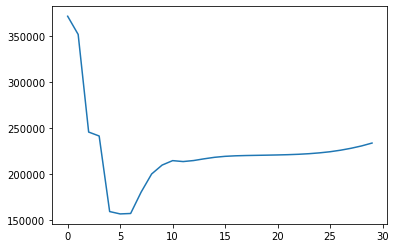

In [156]:
import matplotlib.pyplot as plt
plt.plot(first)

In [157]:
search.best_params_

{'poly__degree': 6}

In [158]:
prd = search.predict(X)
df['Pred']=prd

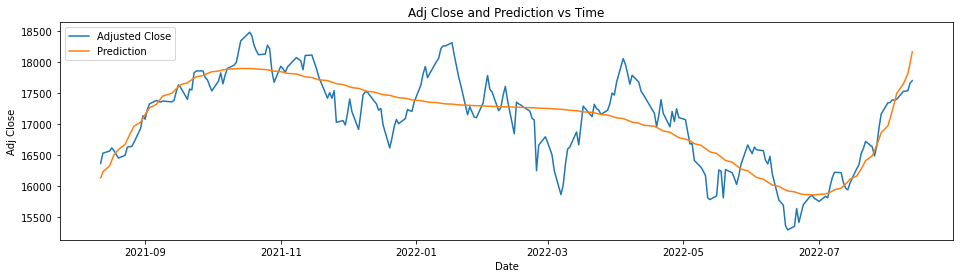

In [159]:
plt.figure(figsize=(16,4))
plt.plot(df['Adj Close'],label='Adjusted Close')
plt.plot(df['Pred'],label='Prediction')
plt.xlabel('Date')

plt.ylabel('Adj Close')
plt.title('Adj Close and Prediction vs Time')
plt.legend()
plt.show()

In [160]:
from sklearn.metrics import mean_squared_error,r2_score
mse = mean_squared_error(df['Pred'],df['Adj Close'])
r2 = r2_score(df['Pred'],df['Adj Close'])
print('Mean Squared Error      : ',round(mse,2))
print('Root Mean Squared Error : ',round(mse**0.5,2))
print('R2 Score                : ',round(r2,4))

Mean Squared Error      :  149831.78
Root Mean Squared Error :  387.08
R2 Score                :  0.5996


In [161]:
df['Residual']=df['Adj Close']-df['Pred']

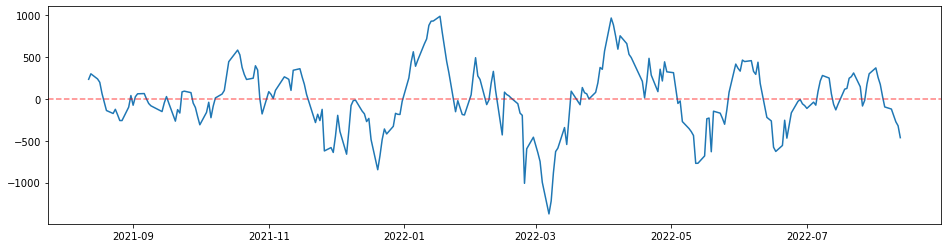

In [162]:
plt.figure(figsize=(16,4))
plt.plot(df['Residual'])
plt.axhline(0,linestyle='--',alpha=0.5,color='red')

In [163]:
df.Residual.mean()

4.270987119525671e-12

In [164]:
s = df.Residual.std()
s

387.85760119923384

In [165]:
df['Upper']= df['Pred']+2*s
df['Lower']=df['Pred']-2*s

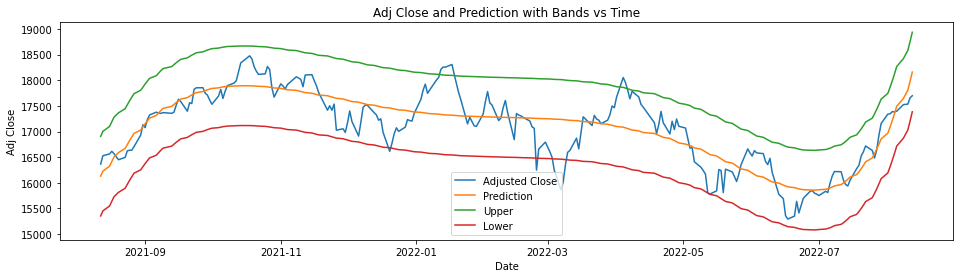

In [166]:
plt.figure(figsize=(16,4))
plt.plot(df['Adj Close'],label='Adjusted Close')
plt.plot(df['Pred'],label='Prediction')
plt.plot(df['Upper'],label='Upper')
plt.plot(df['Lower'],label='Lower')
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.title('Adj Close and Prediction with Bands vs Time')
plt.legend()
plt.show()

In [167]:
df.tail(1)

,Adj Close,Day,Pred,Residual,Upper,Lower
Date,,,,,,
2022-08-12,17698.150391,250,18161.117616,-462.967226,18936.832819,17385.402414


In [168]:
pt = search.predict([df['Day'].tail(1)+1])[0][0]

In [169]:
print('Tomorrows Prediction : ',round(pt,2),'+/-',round(2*s,2))
print('Tomorrows Upper      : ',round(pt+2*s,2))
print('Tomorrows Lower      : ',round(pt-2*s,2))

Tomorrows Prediction :  18352.99 +/- 775.72
Tomorrows Upper      :  19128.7
Tomorrows Lower      :  17577.27


In [170]:
from statsmodels.tsa.stattools import adfuller
#
# Run the test
#
df_stationarityTest = adfuller(df['Residual'], autolag='AIC')
#
# Check the value of p-value
#
print("P-value: ", df_stationarityTest[1])

P-value:  0.003436318625403022


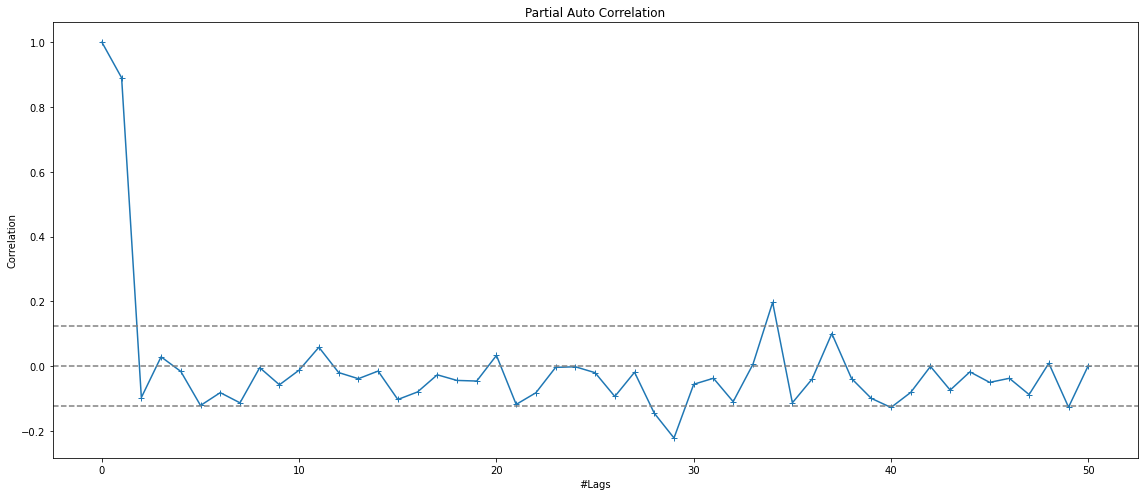

In [171]:
from statsmodels.tsa.stattools import pacf
import numpy as np
PACF_lag = pacf(df['Residual'],nlags=50,method='ols')

plt.figure(figsize=(16,7))
plt.plot(PACF_lag,marker='+')
plt.axhline(0,linestyle='--',color='gray')
plt.axhline(-1.96/np.sqrt(len(df)),linestyle='--',color='gray')
plt.axhline(1.96/np.sqrt(len(df)),linestyle='--',color='gray')
plt.title('Partial Auto Correlation')
plt.xlabel('#Lags')
plt.ylabel('Correlation')
plt.tight_layout()

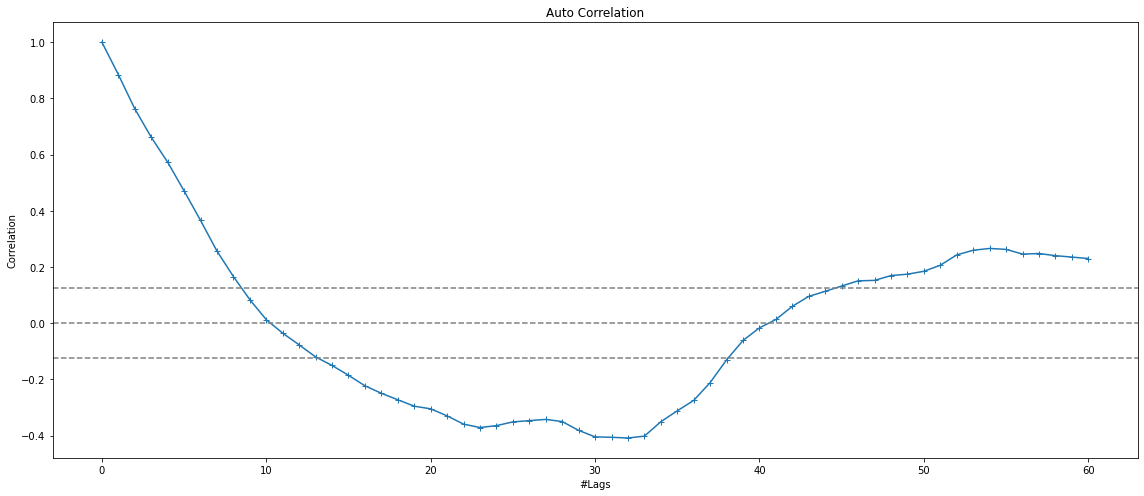

In [172]:
from statsmodels.tsa.stattools import acf

ACF_lag = acf(df['Residual'],nlags=60)
plt.figure(figsize=(16,7))
plt.plot(ACF_lag,marker='+')
plt.axhline(0,linestyle='--',color='gray')
plt.axhline(-1.96/np.sqrt(len(df)),linestyle='--',color='gray')
plt.axhline(1.96/np.sqrt(len(df)),linestyle='--',color='gray')
plt.title('Auto Correlation')
plt.xlabel('#Lags')
plt.ylabel('Correlation')
plt.tight_layout()

In [173]:
n = int(0.8*len(df))
train = df[0:n+1]['Residual']
test = df[n:]['Residual']
train.index = range(len(train))
test.index=range(n,len(df))

In [186]:
from statsmodels.tsa.ar_model import AutoReg
model = AutoReg(train,lags=54).fit()

In [187]:
rpr = model.predict()
rpr

0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
          ...    
196     53.274813
197    349.097082
198    348.198233
199    132.283354
200    549.570488
Length: 201, dtype: float64

In [188]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:               Residual   No. Observations:                  201
Model:                    AutoReg(54)   Log Likelihood                -963.795
Method:               Conditional MLE   S.D. of innovations            170.288
Date:                Sun, 14 Aug 2022   AIC                             11.037
Time:                        08:39:15   BIC                             12.176
Sample:                            54   HQIC                            11.500
                                  201                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        3.4347     14.272      0.241      0.810     -24.538      31.407
Residual.L1      0.8536      0.082     10.402      0.000       0.693       1.014
Residual.L2     -0.0584      0.110     -0.530      0.596      -0.274       0.157
Residual.L3     -0.0252      0.111     -0.228      0.820      -0.242       0.192
Residual.L4      0.1228      0.110      1.114      0.265      -0.093       0.339
Residual.L5      0.0121      0.111      0.108      0.914      -0.206       0.230
Residual.L6     -0.0168      0.111     -0.152      0.879      -0.234       0.200
Residual.L7     -0.2164      0.111     -1.958      0.050      -0.433       0.000
Residual.L8     -0.0102      0.112     -0.091      0.927      -0.229       0.209
Residual.L9      0.0293      0.112      0.262      0.794      -0.190       0.249
Residual.L10    -0.1016      0.112     -0.906      0.365      -0.321       0.118
Residual.L11     0.0480      0.114      0.422      0.673      -0.175       0.271
Residual.L12     0.0525      0.116      0.453      0.651      -0.175       0.280
Residual.L13    -0.0284      0.117     -0.242      0.808      -0.258       0.201
Residual.L14    -0.0417      0.118     -0.354      0.724      -0.273       0.189
Residual.L15     0.0641      0.117      0.546      0.585      -0.166       0.294
Residual.L16    -0.1838      0.117     -1.569      0.117      -0.413       0.046
Residual.L17     0.0359      0.119      0.301      0.764      -0.198       0.270
Residual.L18     0.0462      0.121      0.382      0.703      -0.191       0.283
Residual.L19    -0.1040      0.121     -0.858      0.391      -0.341       0.133
Residual.L20     0.0786      0.120      0.654      0.513      -0.157       0.314
Residual.L21    -0.0369      0.116     -0.317      0.751      -0.265       0.191
Residual.L22    -0.1326      0.113     -1.170      0.242      -0.355       0.089
Residual.L23     0.0513      0.115      0.447      0.655      -0.174       0.276
Residual.L24    -0.1098      0.116     -0.946      0.344      -0.337       0.118
Residual.L25     0.0844      0.117      0.723      0.469      -0.144       0.313
Residual.L26    -0.0186      0.114     -0.163      0.871      -0.243       0.205
Residual.L27    -0.0007      0.113     -0.007      0.995      -0.222       0.221
Residual.L28     0.1067      0.114      0.938      0.348      -0.116       0.330
Residual.L29    -0.2137      0.114     -1.872      0.061      -0.438       0.010
Residual.L30    -0.0247      0.115     -0.214      0.831      -0.251       0.201
Residual.L31     0.0628      0.116      0.540      0.589      -0.165       0.291
Residual.L32    -0.0741      0.116     -0.637      0.524      -0.302       0.154
Residual.L33    -0.2787      0.117     -2.388      0.017      -0.507      -0.050
Residual.L34     0.3144      0.119      2.645      0.008       0.081       0.547
Residual.L35    -0.0628      0.124     -0.505      0.614      -0.307       0.181
Residual.L36    -0.1415      0.126     -1.125      0.260      -0.388       0.105
R

In [189]:
test

200    447.060297
201    457.953422
202    329.747181
203    293.907519
204    439.191666
205    185.406845
206   -220.495073
207   -242.417641
208   -263.213663
209   -576.946011
210   -627.675787
211   -556.222166
212   -254.458371
213   -468.659408
214   -315.956242
215   -166.085881
216    -28.237158
217     -7.404321
218    -58.338292
219    -79.691278
220   -113.223880
221    -38.249516
222    -74.237042
223     89.889363
224    214.650501
225    280.309922
226    249.780088
227     62.063696
228    -63.888985
229   -130.686068
230    -63.639633
231    117.232224
232    125.705307
233    247.049423
234    266.878881
235    310.649472
236    145.665211
237    -84.381713
238    -15.950089
239    175.438109
240    300.512084
241    371.289234
242    257.928572
243    173.840004
244     32.567049
245    -95.697632
246   -120.821320
247   -273.176642
248   -320.545971
249   -462.967226
Name: Residual, dtype: float64

In [190]:
rpr_test = model.predict(start=n,end=len(df))

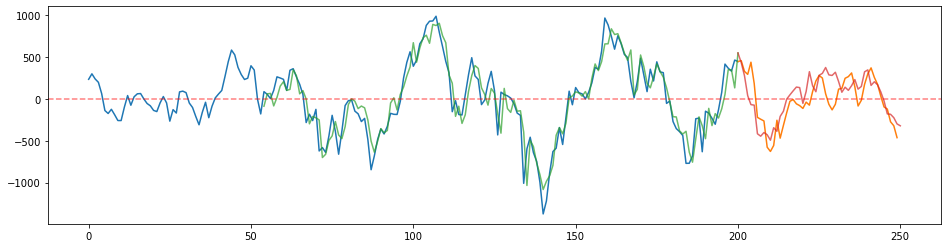

In [191]:
plt.figure(figsize=(16,4))
plt.plot(train)
plt.plot(test)
plt.plot(rpr,alpha=0.7)
plt.plot(rpr_test,alpha=0.7)
plt.axhline(0,linestyle='--',alpha=0.5,color='red')

In [192]:
from statsmodels.tsa.ar_model import AutoReg
data=df['Residual']
data.index = range(len(df))
model2 = AutoReg(data,lags=31).fit()

In [193]:
prf = model2.predict()
prf

0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
          ...    
245     40.014164
246   -100.313386
247   -149.933166
248   -292.919730
249   -300.939526
Length: 250, dtype: float64

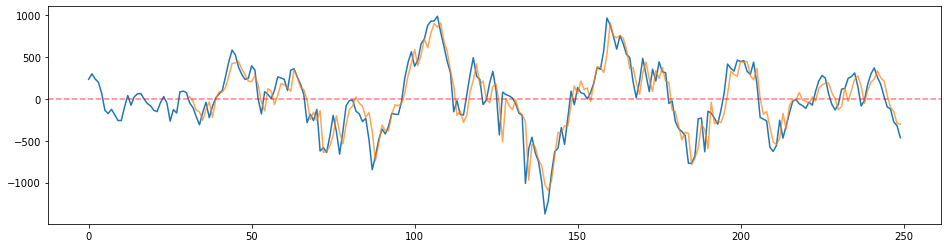

In [194]:
plt.figure(figsize=(16,4))
plt.plot(data)
plt.plot(prf,alpha=0.7)
plt.axhline(0,linestyle='--',alpha=0.5,color='red')

In [195]:
residual_t = model2.predict(start=248,end=250)[250]
residual_t

-411.56591203972

In [196]:
df.tail(1)

,Adj Close,Day,Pred,Residual,Upper,Lower
Date,,,,,,
2022-08-12,17698.150391,250,18161.117616,-462.967226,18936.832819,17385.402414


In [197]:
print('Tomorrows Prediction with residual inclusion : ',round(pt+residual_t,2))

Tomorrows Prediction with residual inclusion :  17941.42
